In [5]:
# System libraries:
%load_ext autoreload
import pandas as pd
import json
import nltk
import numpy as np
import os
import sys
from IPython.core.interactiveshell import InteractiveShell
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
import re
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
integrum_local_lemmas = pd.read_csv('data/processed/integrum_local_lemmas.csv', converters = {'lemmas_content' : eval, 'lemmas_headline':eval})

In [94]:
integrum_federal_lemmas = pd.read_csv('data/processed/integrum_federal_lemmas.csv', converters = {'lemmas_content' : eval, 'lemmas_headline':eval})

In [108]:
integrum_local_lemmas.iloc[:5]
integrum_federal_lemmas.iloc[:5]

year                                     lemmas_content  \
0  2000  [начальник, выборгский, таможня, иван, иоч, да...   
1  2000  [только, замедление, темп, рост, американский,...   
2  2000  [оао, lt, газпром, gt, завершать, длиться, год...   
3  2000  [во, дворец, спорт, ска, хоккей, играть, на, м...   
4  2000  [на, собрание, акционер, оао, lt, квернер, выб...   

                         lemmas_headline  
0              [таможня, разблокировать]  
1                           [что, плохо]  
2  [lt, газпром, gt, протягивать, ветка]  
3           [бизнесмен, драться, клюшка]  
4   [Kvaerner, исчезать, карта, область]

year                                     lemmas_content  \
0  2003  [о, чешский, тренер, владимир, вуйтек, нынче, ...   
1  2003  [в, минувший, воскресение, исполняться, год, д...   
2  2003  [в, минувший, выходной, греция, завершаться, 1...   
3  2003  [сотрудник, мид, финляндия, разыскивать, живой...   
4  2003  [EXXON, MOBIL, намерен, развивать, сотрудничес...   

                                     lemmas_headline  
0  [владимир, вуйтек, главный, тренер, хоккейный,...  
1                                [судьба, маргарита]  
2                  [девушка, кокошник, лицо, россия]  
3                           [не, проходить, полвека]  
4                                          [хроника]

In [110]:
def get_corpus_tfidf(documents):
    dictionary = Dictionary(documents)
    n_items = len(dictionary)
    corpus = [dictionary.doc2bow(text) for text in documents]
    tfidf = models.TfidfModel(corpus)
    return tfidf[corpus], dictionary

In [30]:
documents = integrum_local_lemmas.lemmas_content
dictionary = Dictionary(documents)
n_items = len(dictionary)
corpus = [dictionary.doc2bow(text) for text in documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [95]:
integrum_local_tfidf = corpus_tfidf 

In [111]:
integrum_federal_tfidf, integrum_federal_dictionary = get_corpus_tfidf(integrum_federal_lemmas.lemmas_content)

In [112]:
#row = corpus_tfidf[0]

def get_top_words(corpus_tfidf, dictionary):
    top_words_series = pd.Series(index=range(0,len(corpus_tfidf)))
    top_words_series.name = 'tf_idf_words'
    for i, row in enumerate(corpus_tfidf):
        # sort the list
        sorted_by_second = sorted(row, key=lambda tup: tup[1])
        # get the top 20 elements
        a = np.array(sorted_by_second[-20:], dtype=np.int32)
        # get the first indices
        idx = a[:,0].tolist()
        #dictionary[a[:,0].tolist()]
        article_top_words = [dictionary[i] for i in idx]
        top_words_series.iloc[i] = article_top_words
        
    return top_words_series


In [113]:
top_words_federal = get_top_words(integrum_federal_tfidf, integrum_federal_dictionary)

In [114]:
top_words_series.iloc[:5]

top_words_federal.iloc[:5]

0    [граница, очередь, приостанавливать, осмотр, у...
1    [котировка, технологичный, замедление, Sonera,...
2    [-, магистраль, освоение, авария, длиться, мес...
3    [банкет, павел, турнир, соперничество, фирма, ...
4    [оправлять, переименовывать, боргский, акционе...
Name: tf_idf_words, dtype: object

0    [никогда, ваш, казань, чербаев, иван, ..., пан...
1    [познакомиться, масленица, писатель, сороковой...
2    [самойленков, федоскинский, регион, байкал, ре...
3    [пелтокоски, жертва, советский, известие, шпио...
4    [автомобиль, SUBARU, юкоссибнефть, EXXON, MOBI...
Name: tf_idf_words, dtype: object

In [82]:
# combine year with tf_idf stuff

integrum_local_lemmas.iloc[:5]

integrum_local_tfidf = pd.concat([integrum_local_lemmas['year'], top_words_series], axis = 1)

integrum_local_tfidf.iloc[:5]

year                                     lemmas_content  \
0  2000  [начальник, выборгский, таможня, иван, иоч, да...   
1  2000  [только, замедление, темп, рост, американский,...   
2  2000  [оао, lt, газпром, gt, завершать, длиться, год...   
3  2000  [во, дворец, спорт, ска, хоккей, играть, на, м...   
4  2000  [на, собрание, акционер, оао, lt, квернер, выб...   

                         lemmas_headline  
0              [таможня, разблокировать]  
1                           [что, плохо]  
2  [lt, газпром, gt, протягивать, ветка]  
3           [бизнесмен, драться, клюшка]  
4   [Kvaerner, исчезать, карта, область]

year                                       tf_idf_words
0  2000  [граница, очередь, приостанавливать, осмотр, у...
1  2000  [котировка, технологичный, замедление, Sonera,...
2  2000  [-, магистраль, освоение, авария, длиться, мес...
3  2000  [банкет, павел, турнир, соперничество, фирма, ...
4  2000  [оправлять, переименовывать, боргский, акционе...

In [115]:
# combine year with tf_idf stuff

integrum_federal_lemmas.iloc[:5]

integrum_federal_tfidf = pd.concat([integrum_federal_lemmas['year'], top_words_federal], axis = 1)

integrum_federal_tfidf.iloc[:5]


year                                     lemmas_content  \
0  2003  [о, чешский, тренер, владимир, вуйтек, нынче, ...   
1  2003  [в, минувший, воскресение, исполняться, год, д...   
2  2003  [в, минувший, выходной, греция, завершаться, 1...   
3  2003  [сотрудник, мид, финляндия, разыскивать, живой...   
4  2003  [EXXON, MOBIL, намерен, развивать, сотрудничес...   

                                     lemmas_headline  
0  [владимир, вуйтек, главный, тренер, хоккейный,...  
1                                [судьба, маргарита]  
2                  [девушка, кокошник, лицо, россия]  
3                           [не, проходить, полвека]  
4                                          [хроника]

year                                       tf_idf_words
0  2003  [никогда, ваш, казань, чербаев, иван, ..., пан...
1  2003  [познакомиться, масленица, писатель, сороковой...
2  2003  [самойленков, федоскинский, регион, байкал, ре...
3  2003  [пелтокоски, жертва, советский, известие, шпио...
4  2003  [автомобиль, SUBARU, юкоссибнефть, EXXON, MOBI...

In [116]:
# Target 1 - continued - get a word cloud using TF-IDF for the whole dataset

# Concatenate selected lists in the data['tfidf_top_words'] and generate a histogram

def get_tf_idf_counts(series):
    tf_idf_flattened = [b for a in series for b in a if b not in ['quot','gt','lt','dsqu','nbsp', "''","``"]]
    counts = Counter(tf_idf_flattened)
    return counts

def output_wordcloud(counts, title = None):
    cloud = WordCloud(stopwords=None, background_color='black', width=2500, height=1800
                     ).generate_from_frequencies(counts)

    plt.figure(figsize=(20,10))
    if title:
        plt.title(title)
    plt.imshow(cloud)
    plt.axis('off')
    # export image to disk with a good name
    plt.show()
    


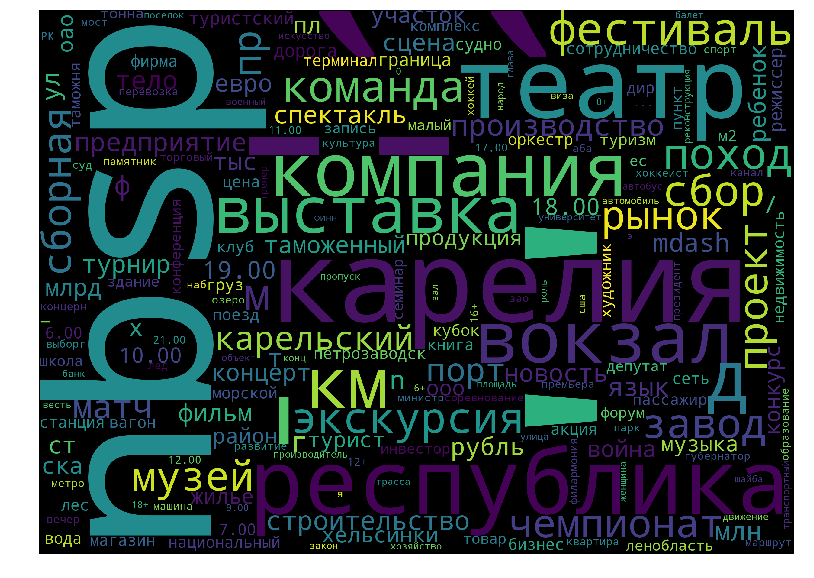

In [87]:
counts = get_tf_idf_counts(top_words_series)  
output_wordcloud(counts)

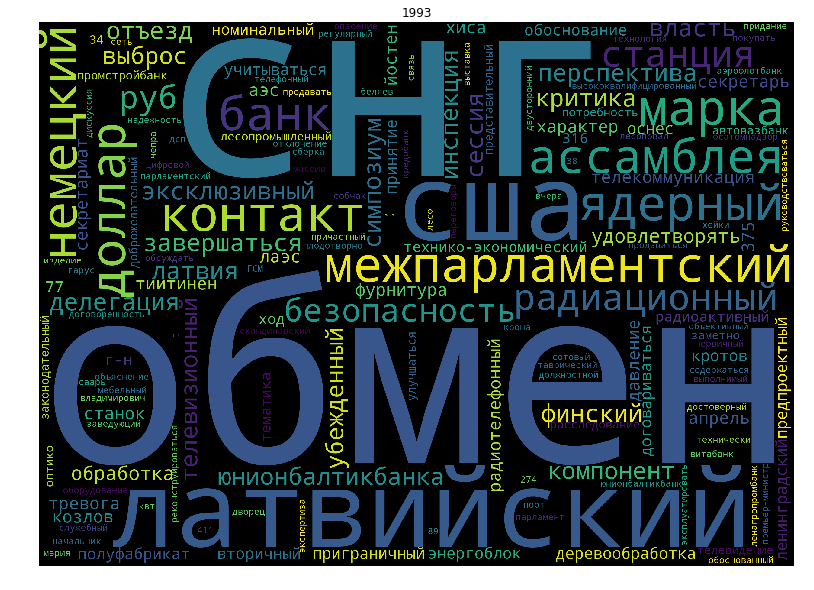

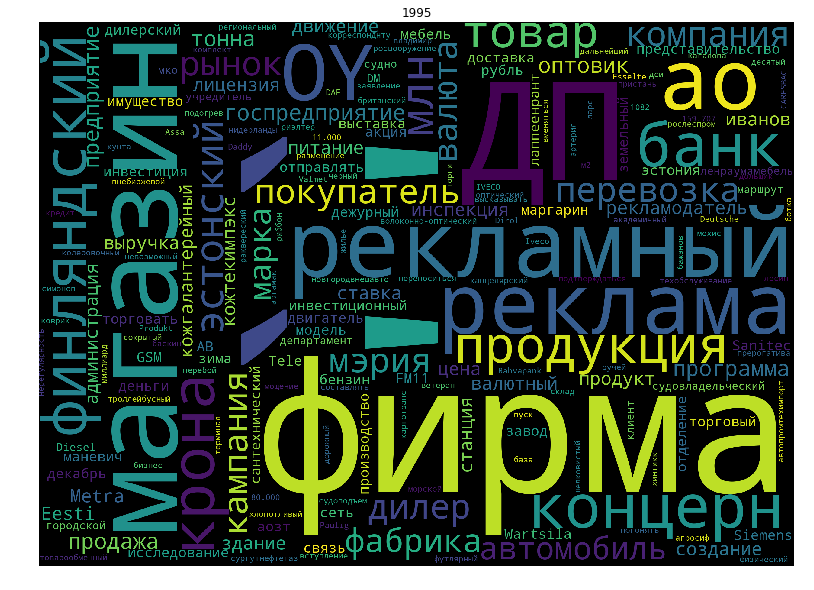

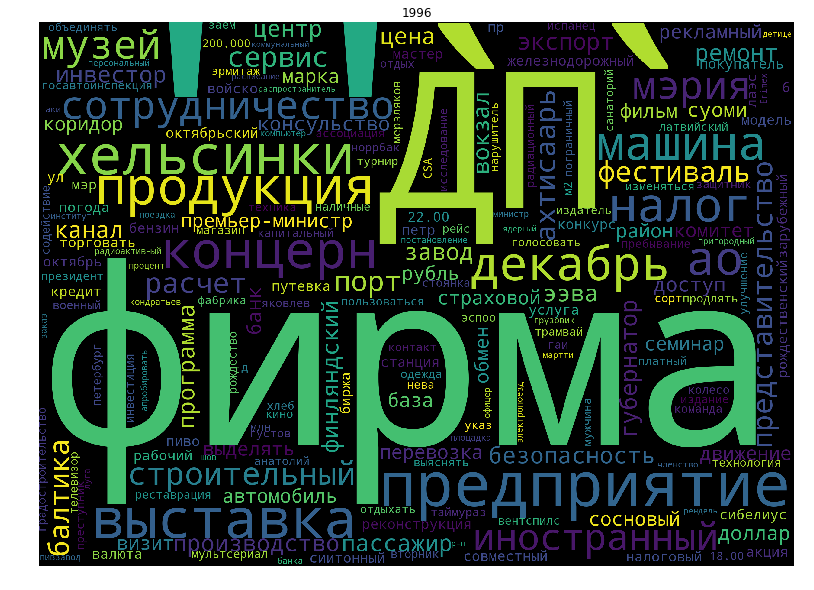

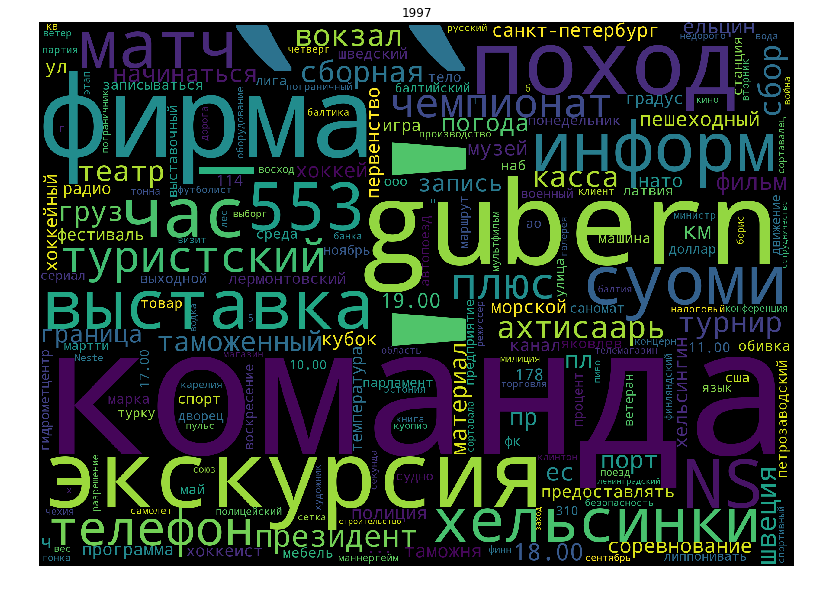

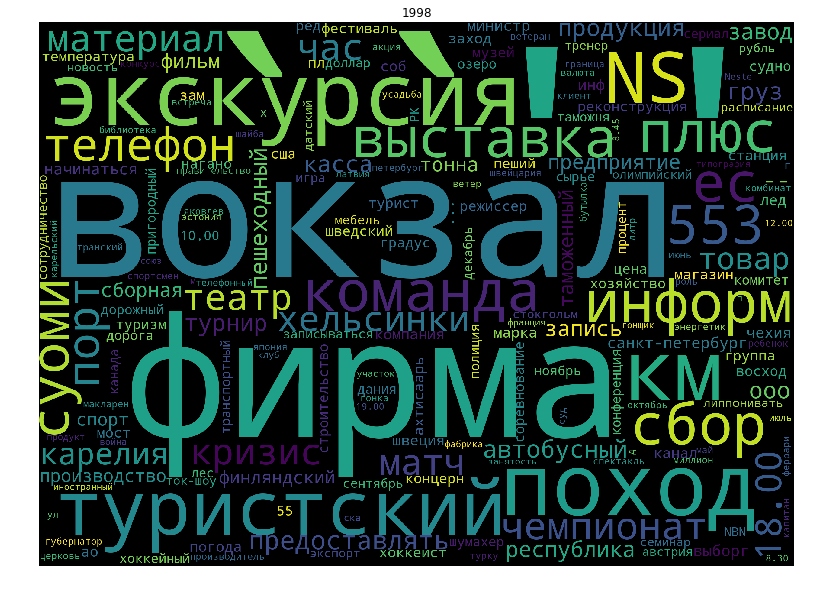

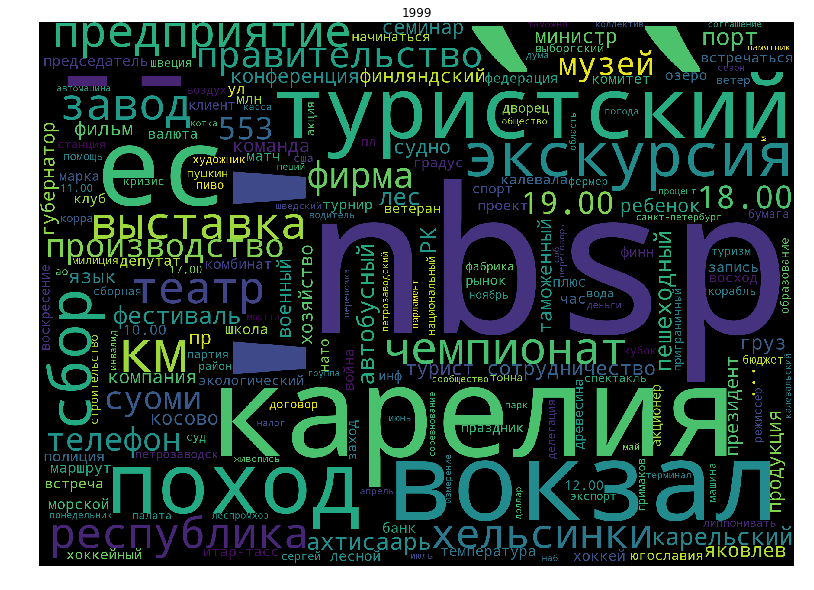

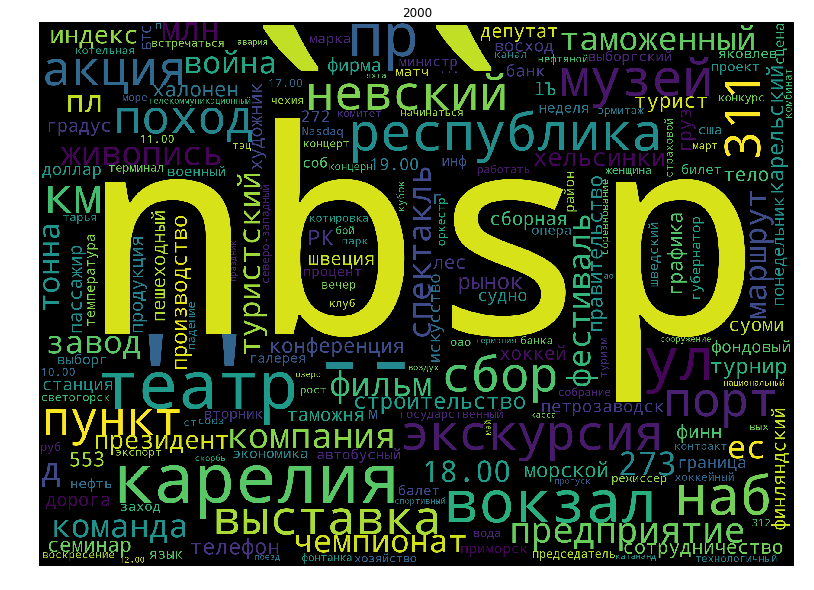

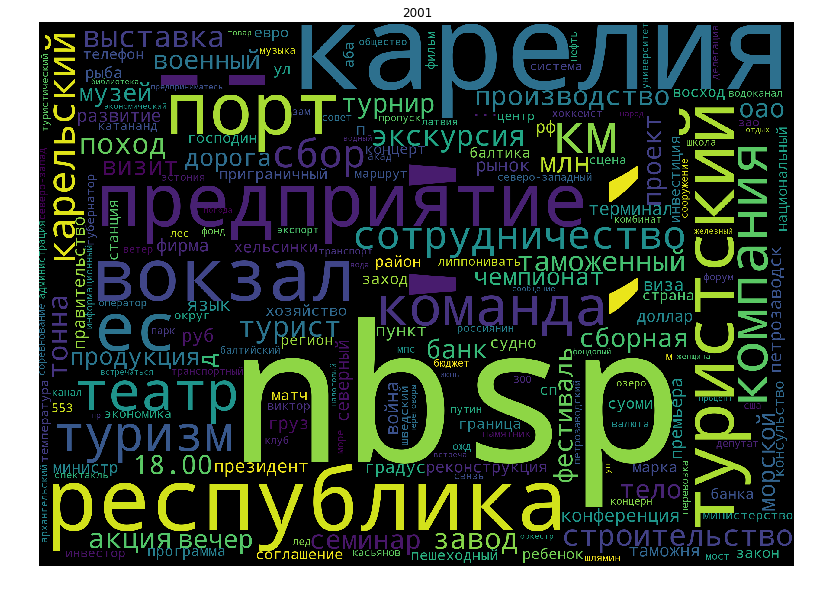

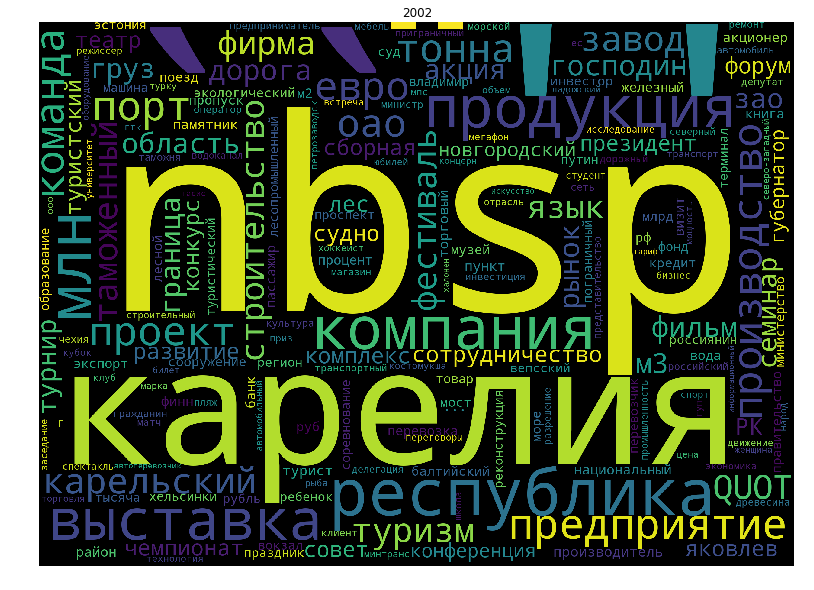

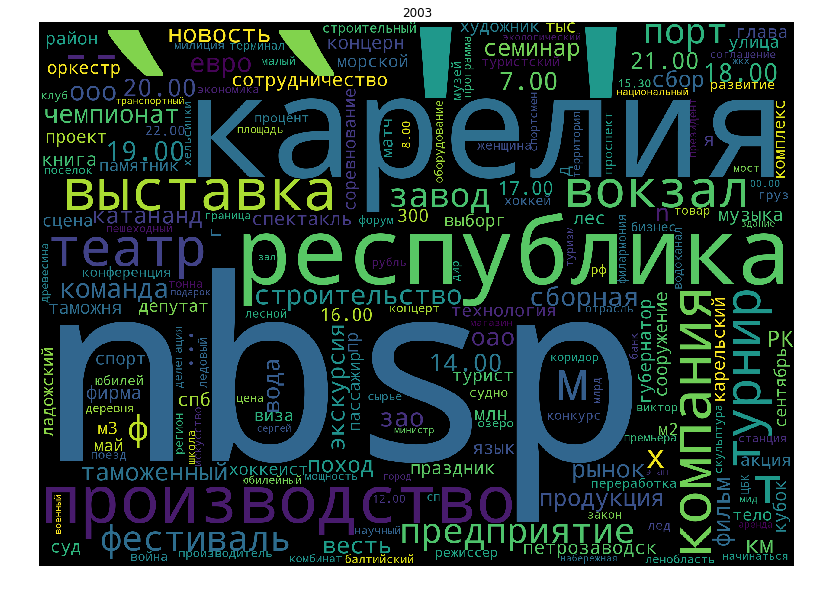

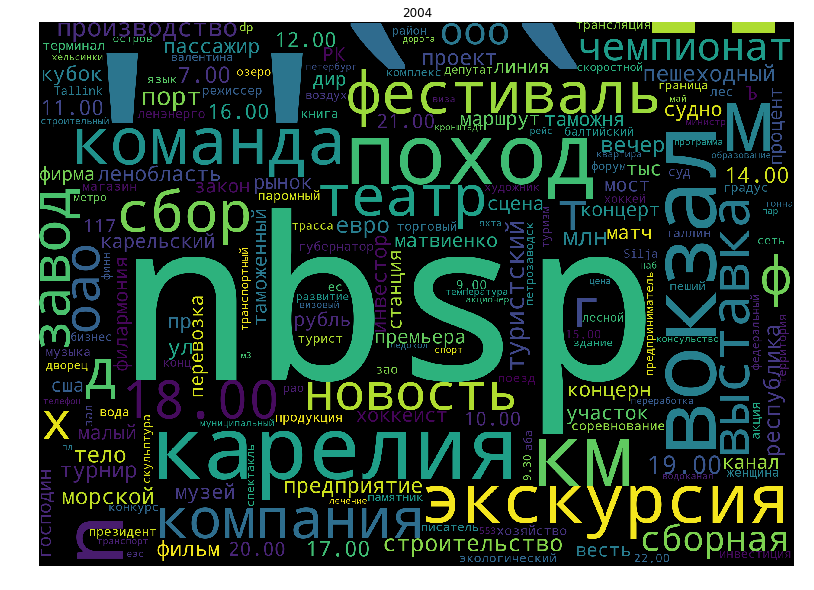

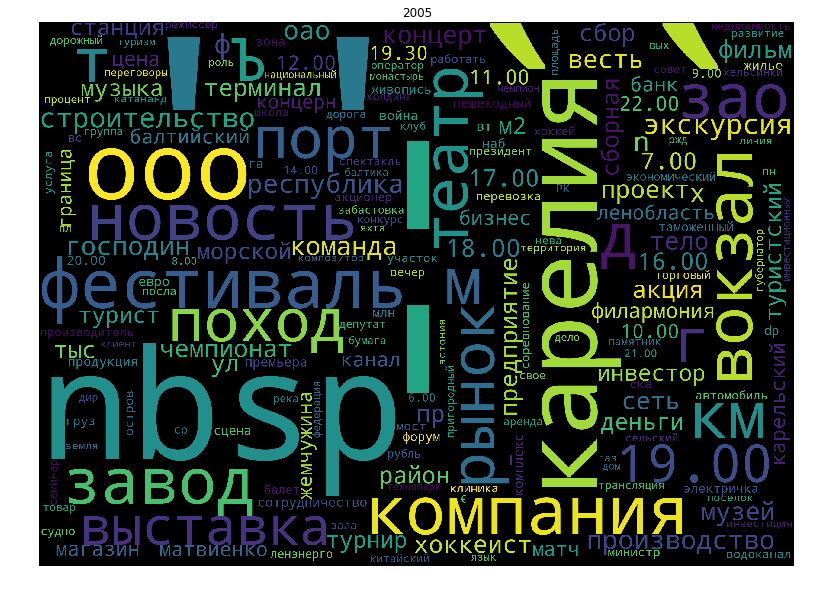

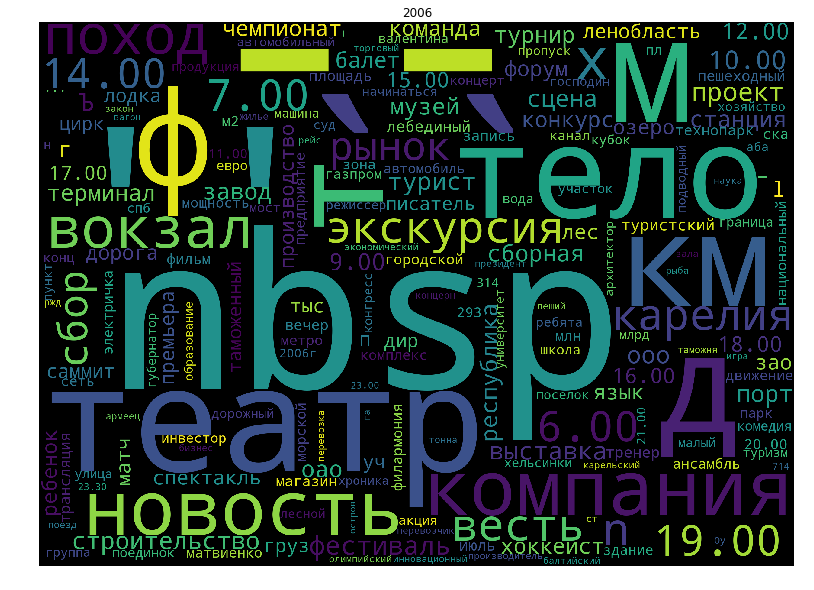

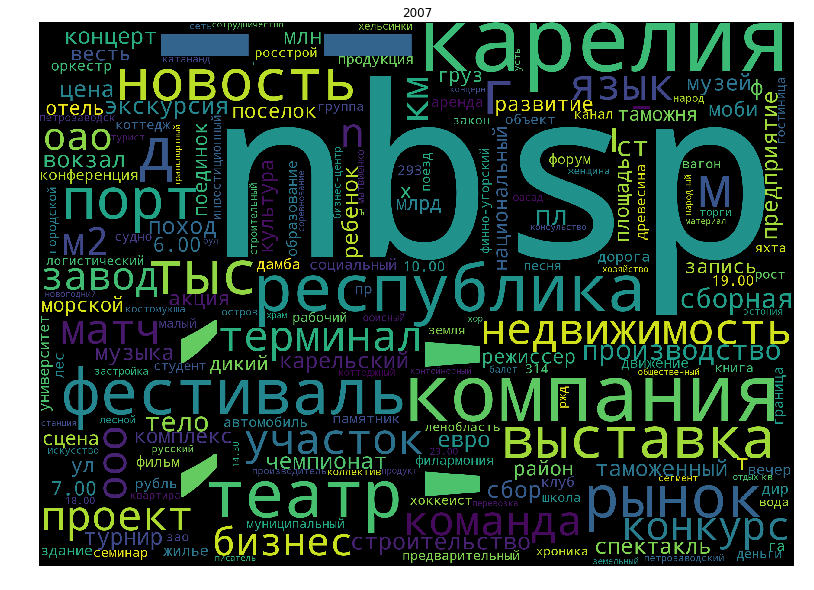

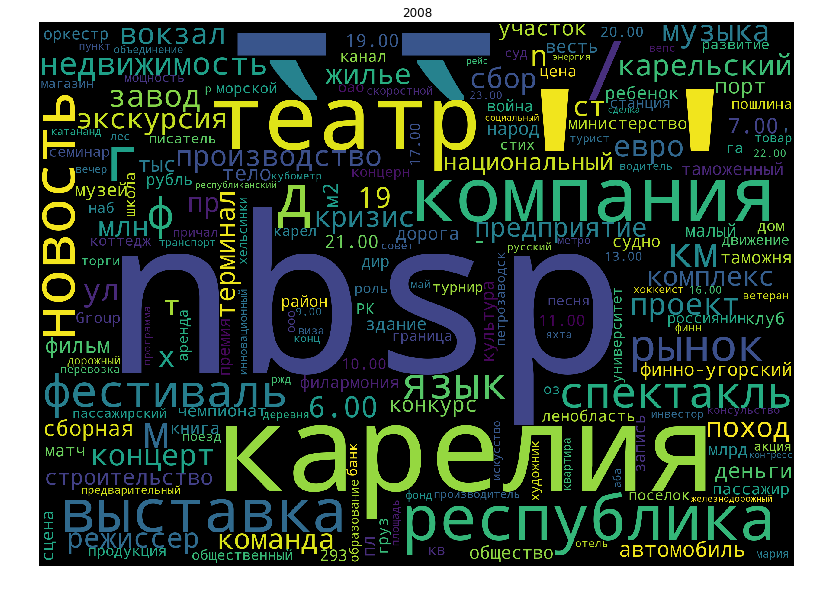

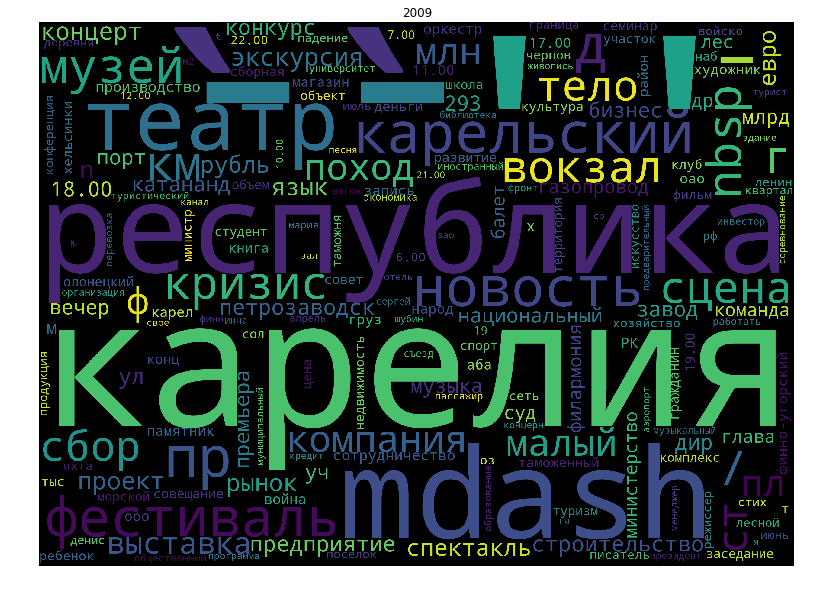

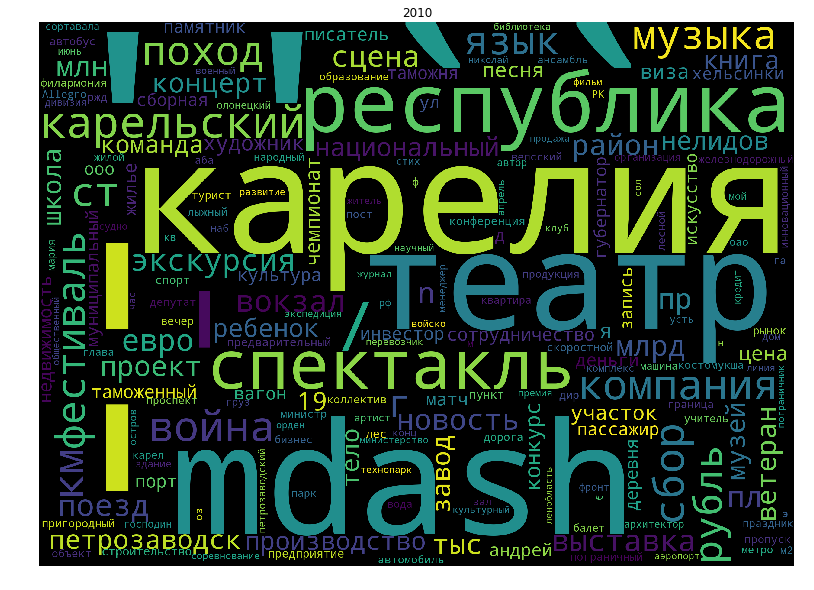

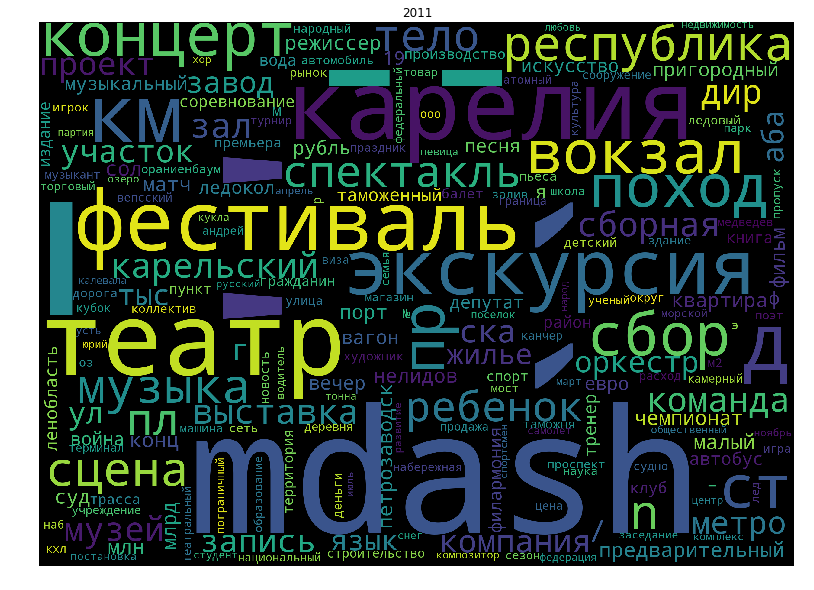

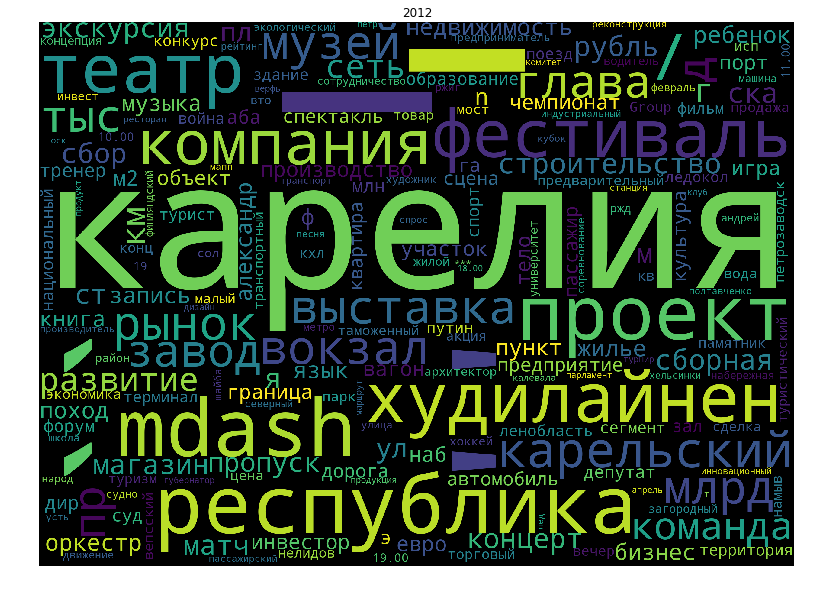

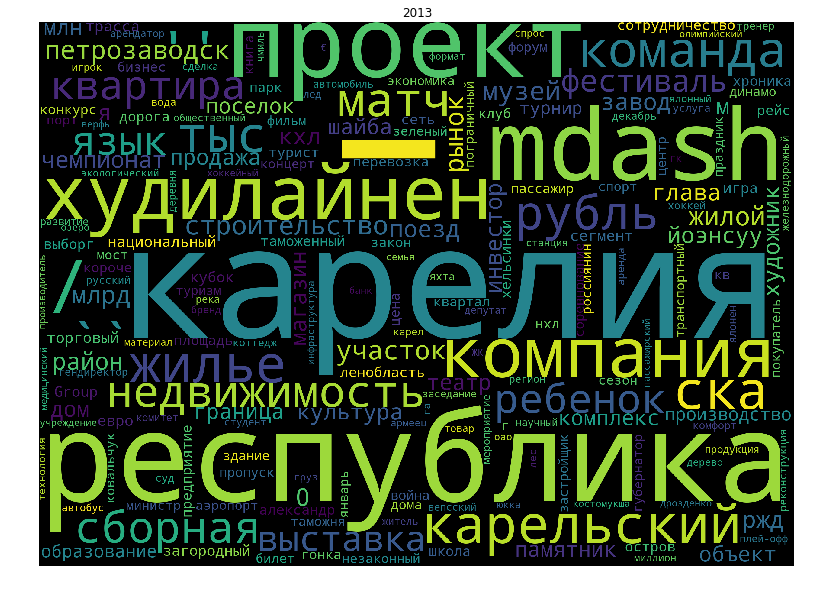

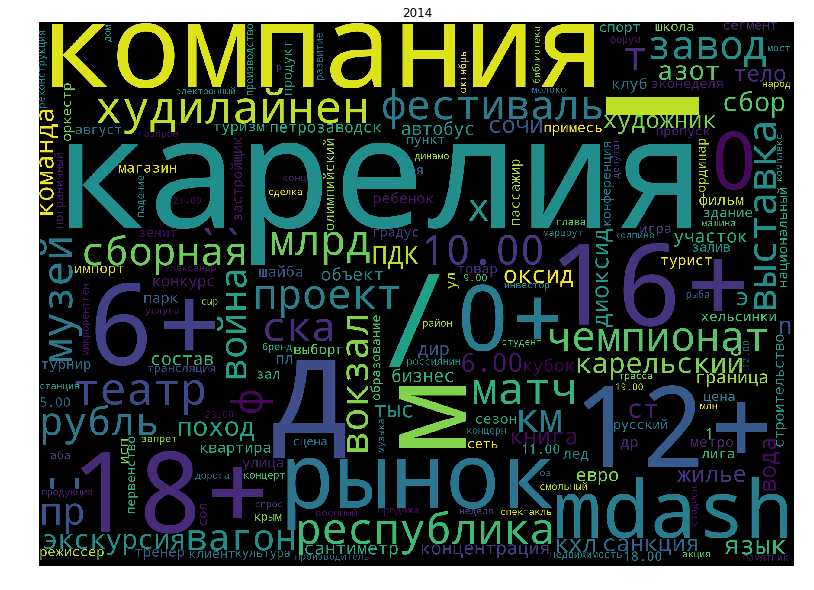

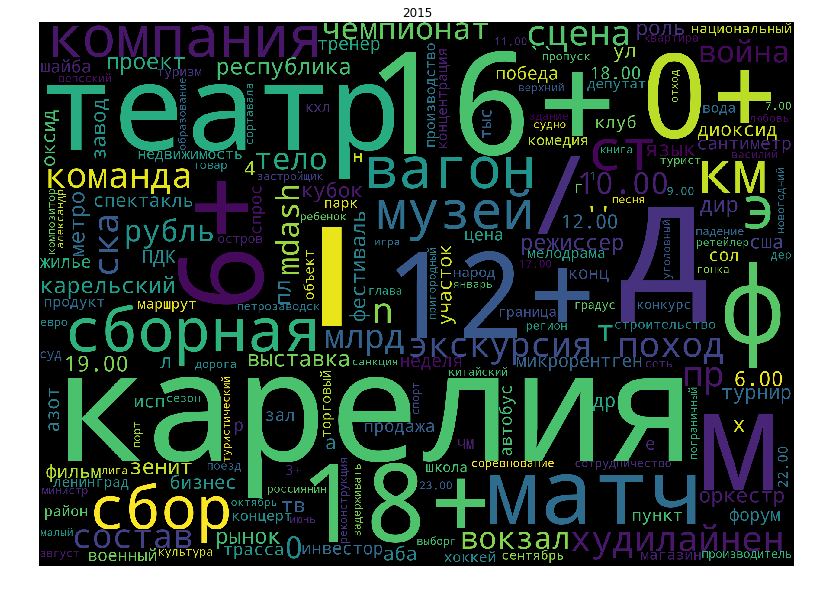

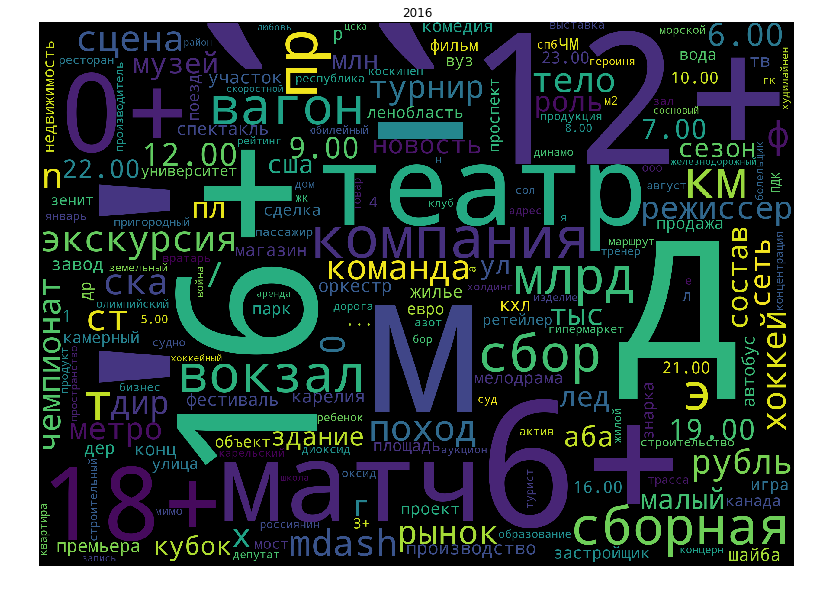

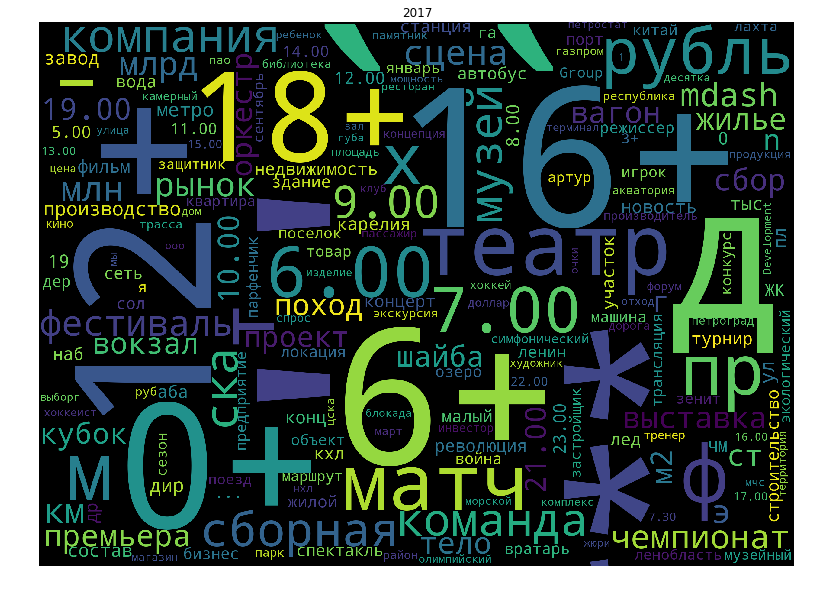

In [93]:
for year in sorted(integrum_local_tfidf.year.unique()):
    yearly_data = integrum_local_tfidf[integrum_local_tfidf['year'] == year].tf_idf_words
    counts = get_tf_idf_counts(yearly_data)  
    output_wordcloud(counts, year)

In [117]:
def print_yearly_wordclouds(tfidf_data):
    for year in sorted(tfidf_data.year.unique()):
        yearly_data = tfidf_data[tfidf_data['year'] == year].tf_idf_words
        counts = get_tf_idf_counts(yearly_data)  
        output_wordcloud(counts, year)

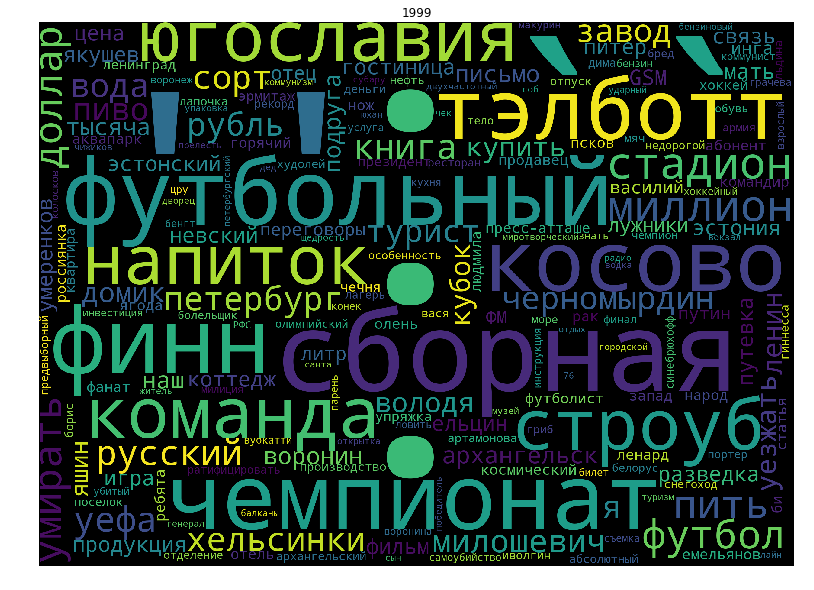

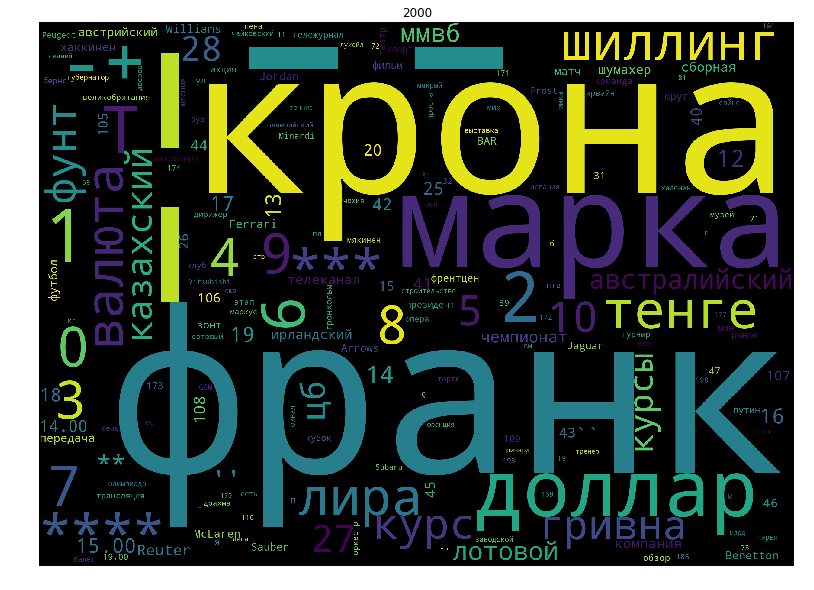

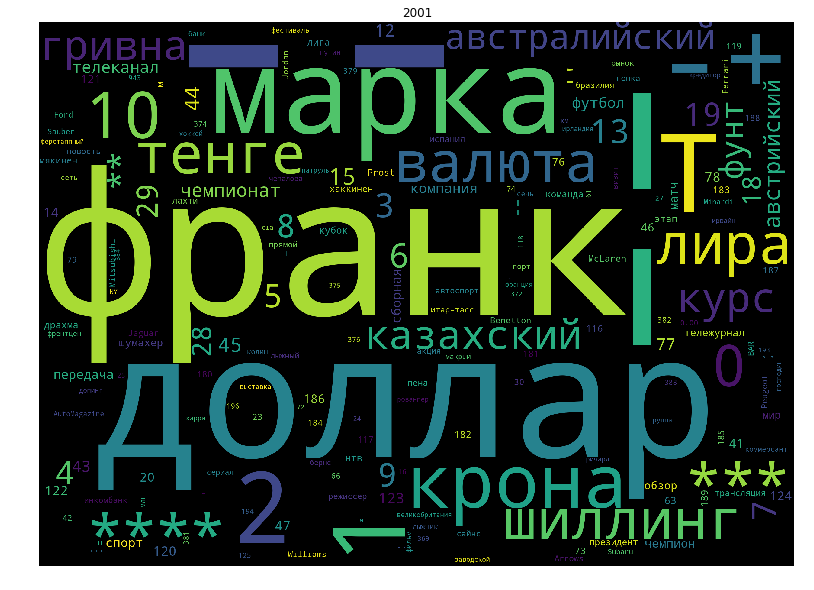

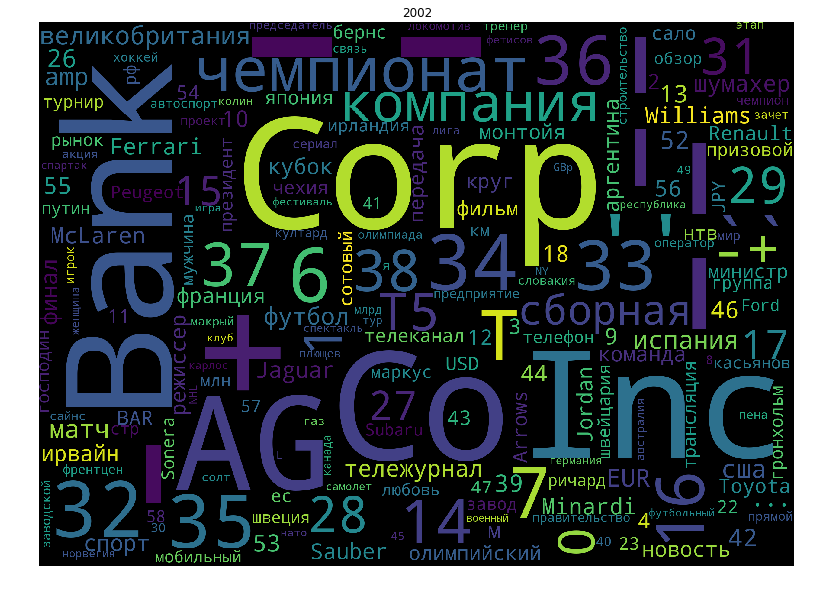

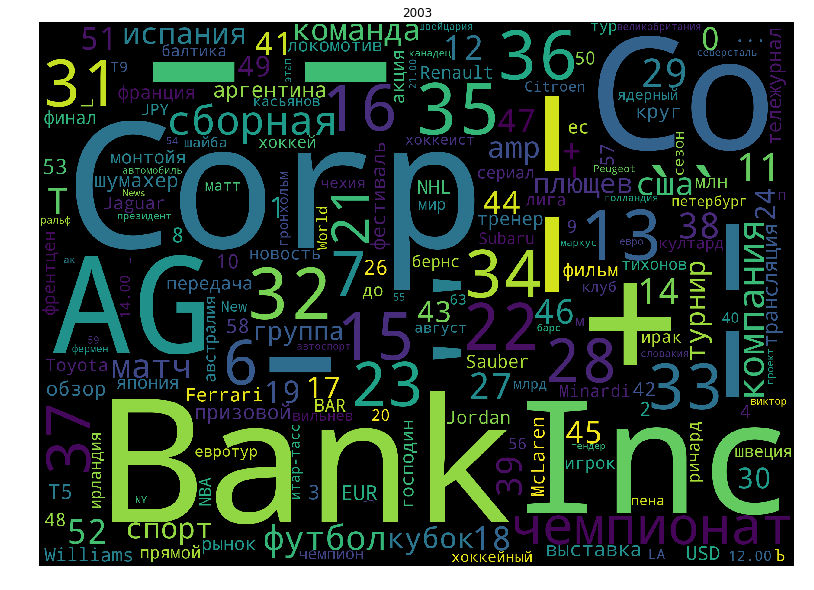

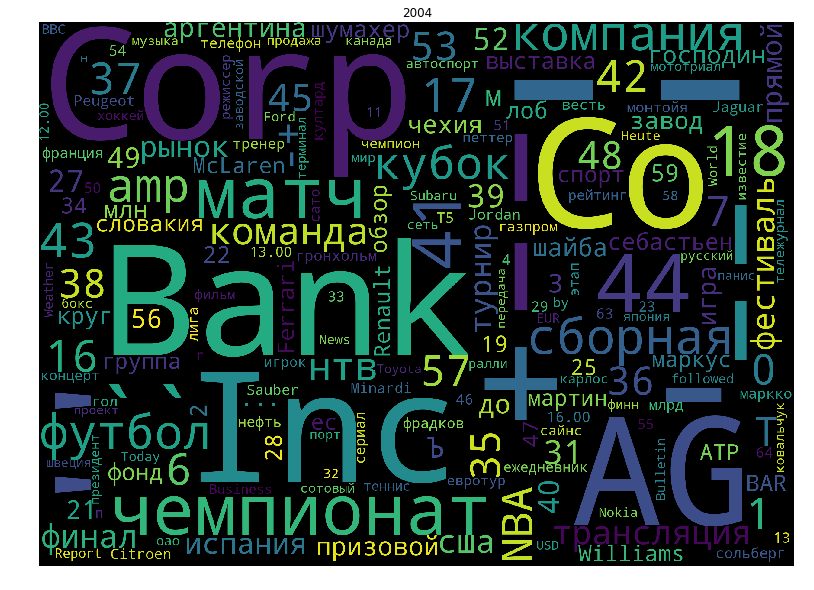

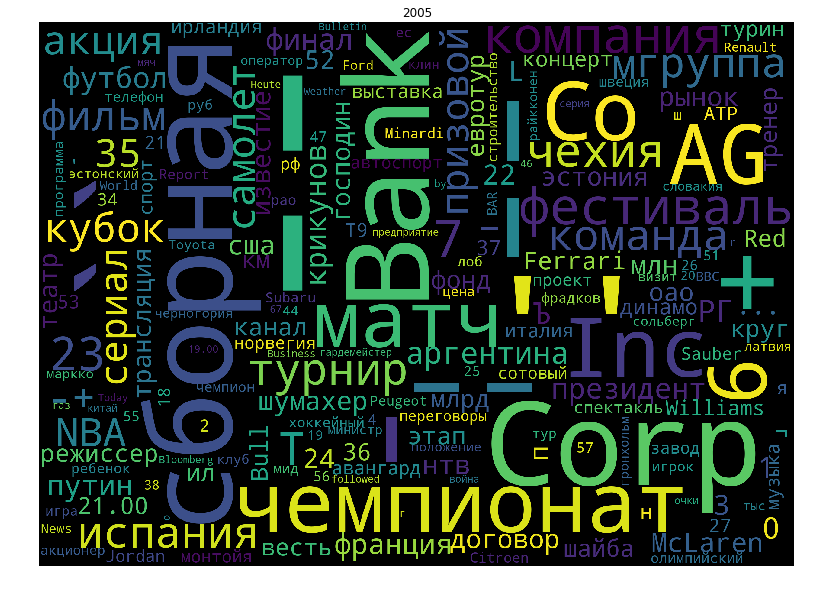

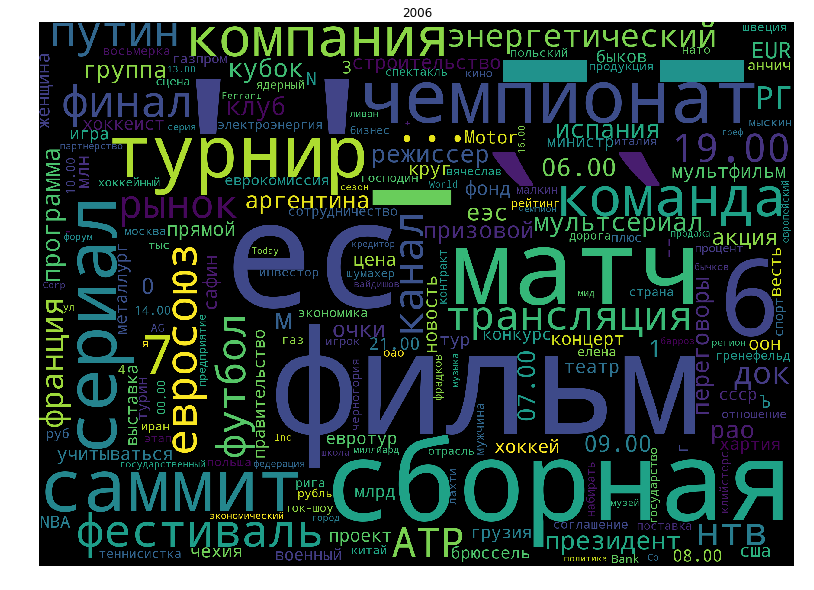

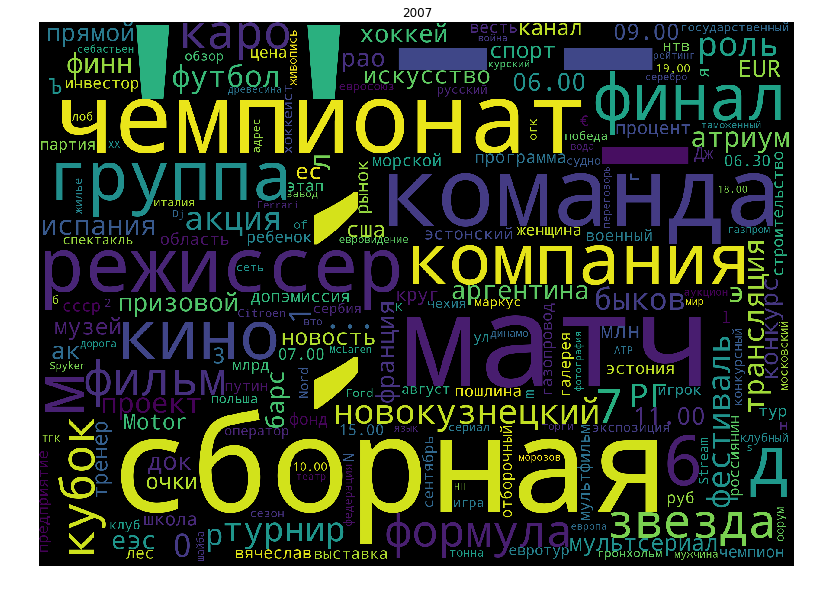

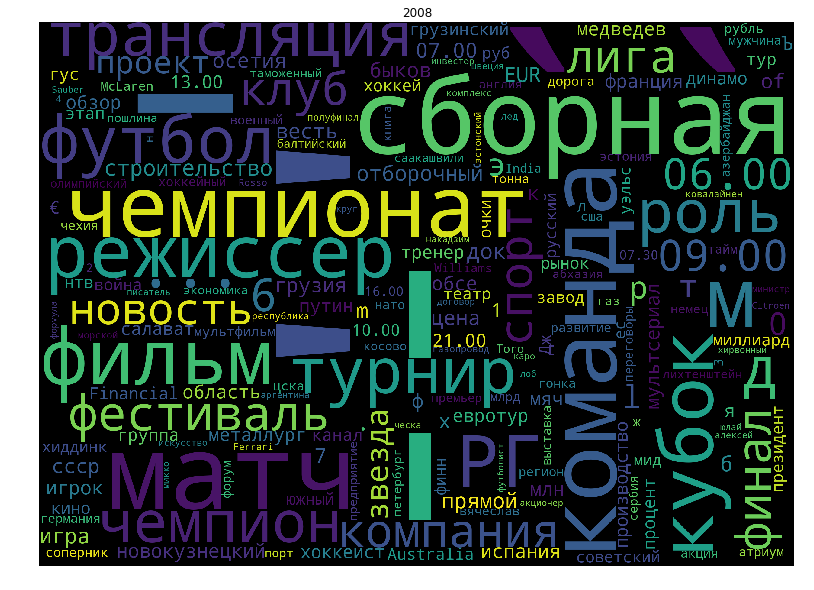

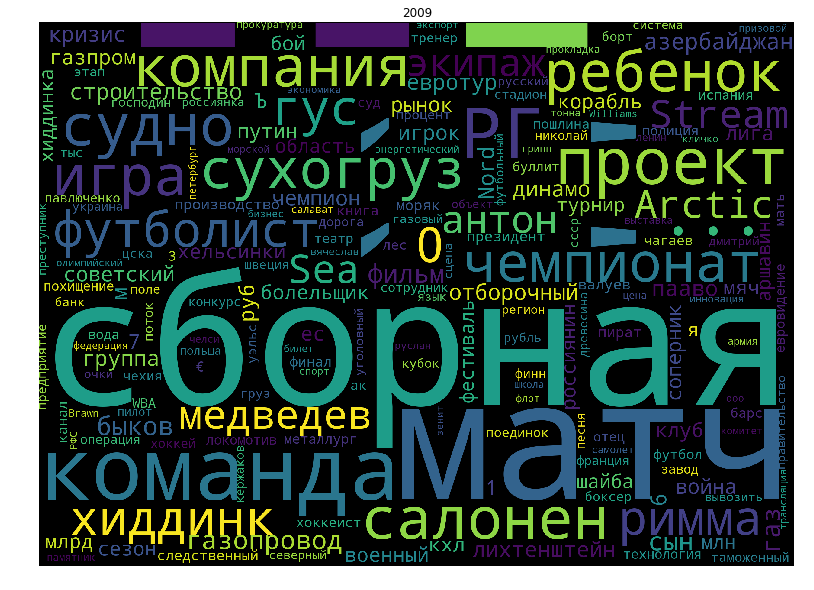

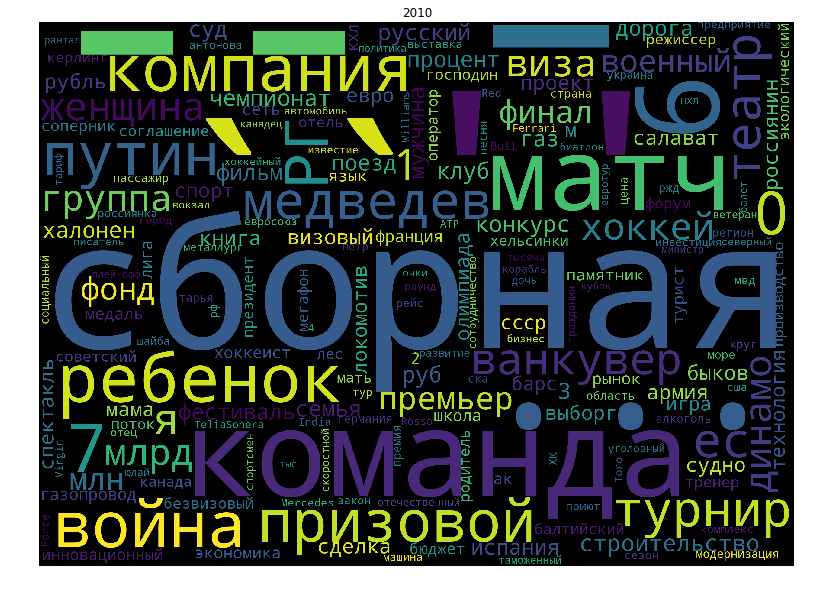

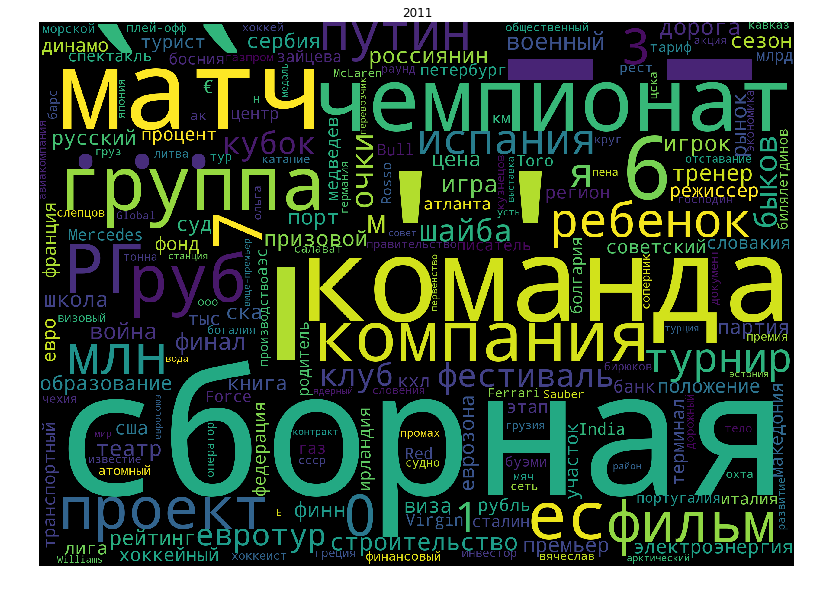

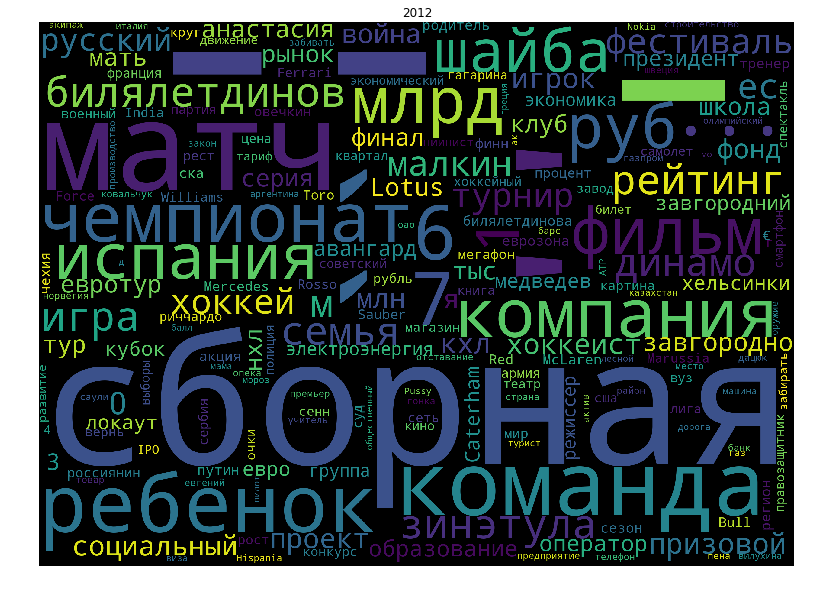

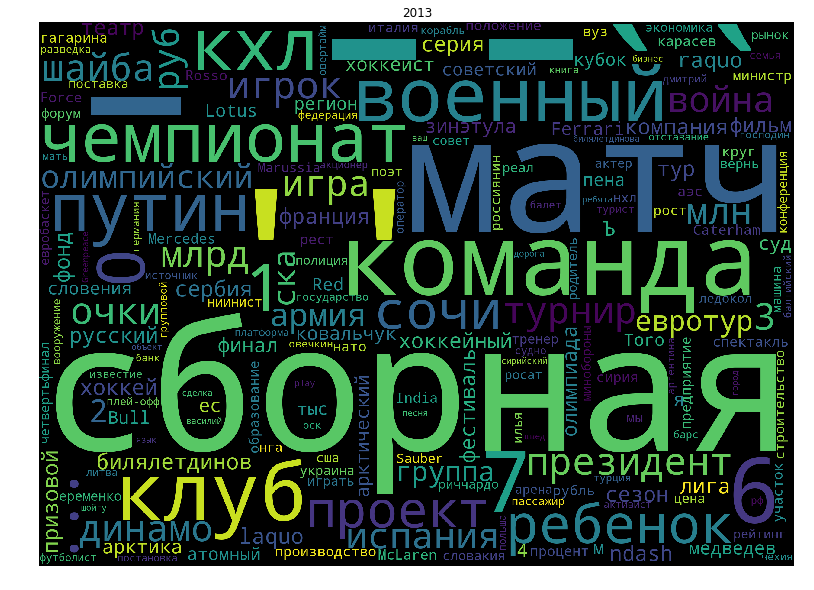

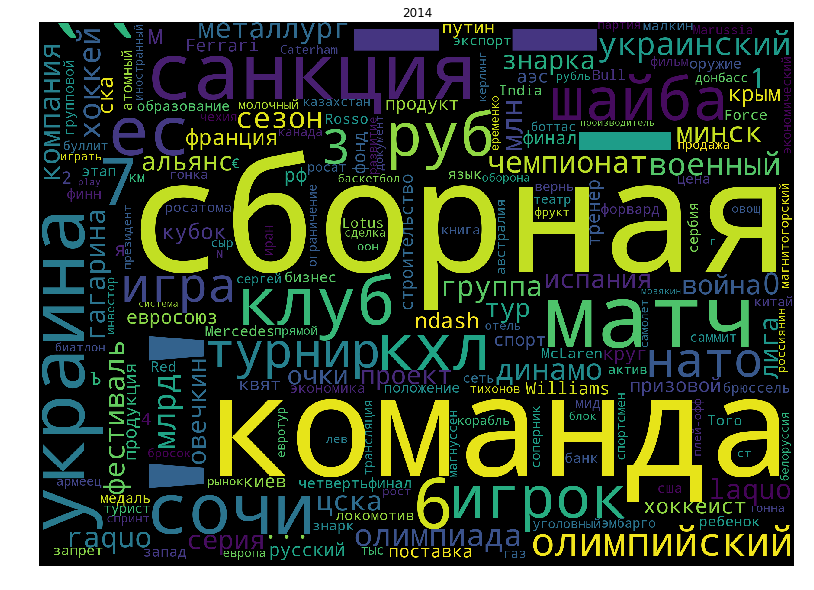

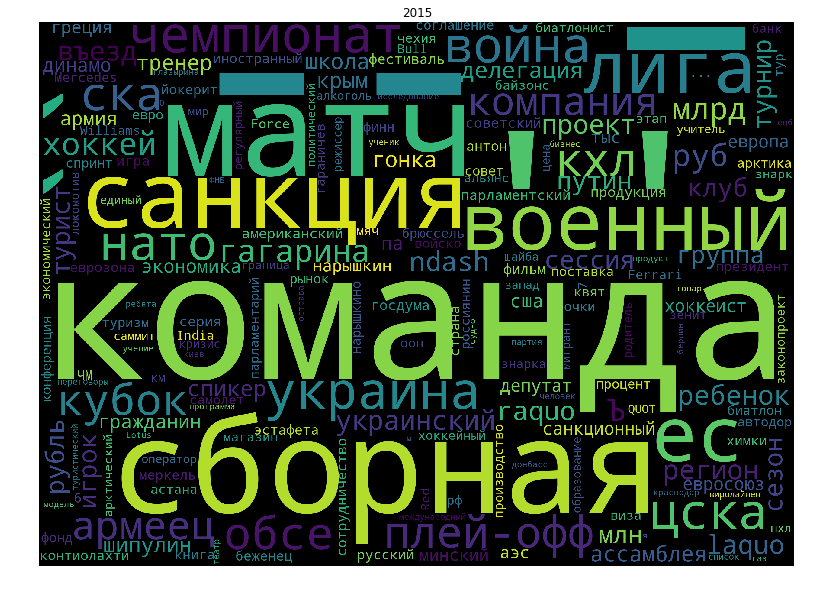

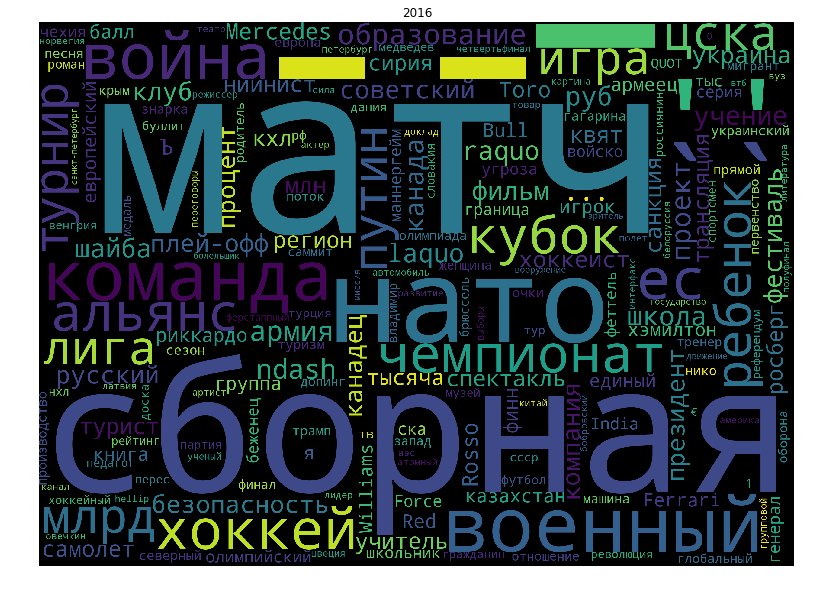

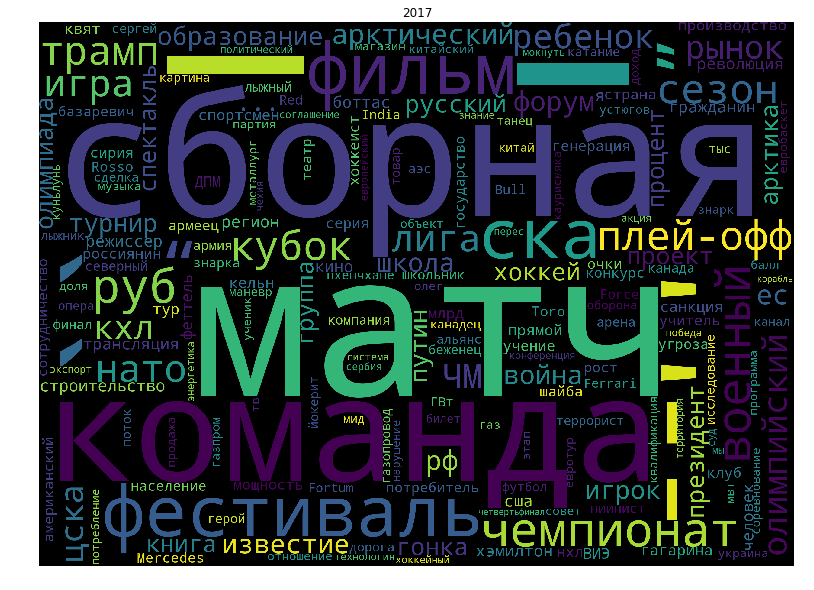

In [118]:
print_yearly_wordclouds(integrum_federal_tfidf)

In [ ]:
# TODO clean out latin characters and numbers